In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import keras
from keras.models import Sequential
from keras.layers import Dense

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
# Set some display options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [4]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

src_preparation_folder = os.path.join(src_folder, 'preparation')
src_processing_folder = os.path.join(src_folder, 'processing')
src_modeling_folder = os.path.join(src_folder, 'modeling')

In [5]:
# Import src functions
sys.path.insert(0, src_preparation_folder)
from import_data import get_table
from import_data import get_data_simple
from import_data import get_patient_admissions_diagnoses
from import_data import get_admission_data
from import_data import get_chartevents
from import_data import get_labevents
from extract_codes import find_ndc_codes

sys.path.insert(0, src_processing_folder)
from stats import plot_KDE
from stats import plot_perc_bar_chart
from stats import compare_groups
from stats import graph_comparisons
from patient_selection import select_test_groups
from clean import replace_itemid_with_label
from clean import find_populated_cols

sys.path.insert(0, src_modeling_folder)
from models import train_lgb

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## FUNCTIONS

In [6]:
'''
Define a function that for a list of item IDs:
    1. Plots a KDE for their values
    2. Outputs a table showing statistical values
    3. If multiple itemids - asseses their similarity to judge whether they can be coalesced
'''
def compare_itemids(df):
    
    print("=========")
    print(str(df.name.values[0]))
    print("=========")
    
    # Drop duplicates and nans
    df.drop_duplicates(inplace=True)    
    df.dropna(inplace=True)
    
    # Find old itemids associated
    item_ids = df.itemid.unique().tolist()

    # --- Plot a KDE
    plt.figure(figsize = (7, 5))

    # KDE plots for each groups
    for i in item_ids:
        sns.kdeplot(df.loc[df['itemid'] == i, 'valuenum'], label = i)

    # Labeling of plot
    plt.ylabel('Density'); plt.title(str(df.name.values[0]));

    plt.show()
    
    # -- Output stats
    stats = (df.groupby('itemid')
               .agg({'hadm_id': 'nunique',
                     'valuenum': ['mean', 'median', 'std']})
               .reset_index())
    stats.columns = ['itemid', 'patients', 'mean', 'median', 'std']
    
    print(stats)
    
    return stats

In [7]:
# Import chart IDs
chart_lab_coalesce = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', 'chart_lab_coalesce.csv')))
chart_lab_coalesce.head()

,new_id,name,itemid,description
0,9999001,Creatinine,50912,Using just from labevents due to high volume i...
1,9999002,Hematocrit,51221,Using just from labevents due to high volume i...
2,9999003,BUN,225624,Combining across sources due to similar distri...
3,9999003,BUN,1162,Combining across sources due to similar distri...
4,9999003,BUN,781,Combining across sources due to similar distri...


In [8]:
# Create list of IDs
ids = tuple(chart_lab_coalesce.itemid.tolist())

In [9]:
# Take all readings for these IDs from the raw data

# Lab events
lab = get_data_simple(query = "SELECT DISTINCT\
                                subject_id\
                                ,hadm_id\
                                ,charttime\
                                ,itemid\
                                ,valuenum\
                            FROM\
                                mimiciii.labevents\
                            WHERE valuenum IS NOT null\
                            AND itemid IN {}".format(ids))

# Lab events
chart = get_data_simple(query = "SELECT DISTINCT\
                                subject_id\
                                ,hadm_id\
                                ,charttime\
                                ,itemid\
                                ,valuenum\
                            FROM\
                                mimiciii.chartevents\
                            WHERE valuenum IS NOT null\
                            AND itemid IN {}".format(ids))

combined_df = lab.append(chart)

In [10]:
df = combined_df.copy()
df.head()

,subject_id,hadm_id,charttime,itemid,valuenum
0,2,163353.0,2138-07-17 20:48:00,51146,0.0
1,2,163353.0,2138-07-17 20:48:00,51200,0.0
2,2,163353.0,2138-07-17 20:48:00,51221,0.0
3,2,163353.0,2138-07-17 20:48:00,51222,0.0
4,2,163353.0,2138-07-17 20:48:00,51244,0.0


In [11]:
# Merge on lookup
df = pd.merge(df, chart_lab_coalesce[['itemid', 'new_id', 'name']], how='left', left_on='itemid', right_on='itemid')
df.head()

,subject_id,hadm_id,charttime,itemid,valuenum,new_id,name
0,2,163353.0,2138-07-17 20:48:00,51146,0.0,9999035,Basophils
1,2,163353.0,2138-07-17 20:48:00,51200,0.0,9999036,Eosinophils
2,2,163353.0,2138-07-17 20:48:00,51221,0.0,9999002,Hematocrit
3,2,163353.0,2138-07-17 20:48:00,51222,0.0,9999009,Hemoglobin
4,2,163353.0,2138-07-17 20:48:00,51244,0.0,9999032,Lymphocytes


In [12]:
new_ids = df.new_id.unique().tolist()
print(len(new_ids))

35


Basophils


/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

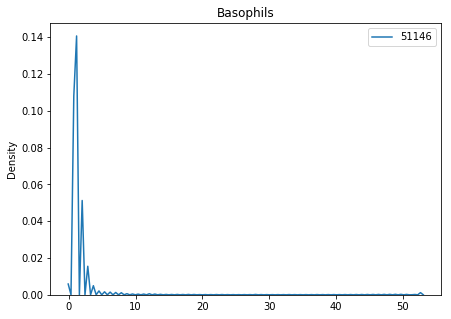

   itemid  patients      mean  median       std
0   51146     44246  0.299635     0.2  0.635749
Basophils


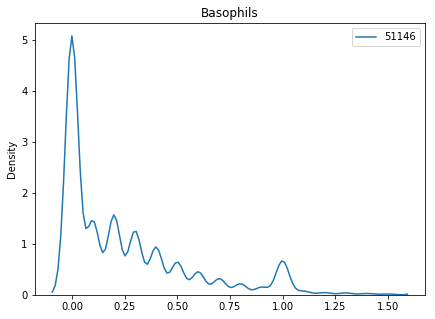

   itemid  patients      mean  median       std
0   51146     43820  0.251741     0.1  0.309373
Eosinophils


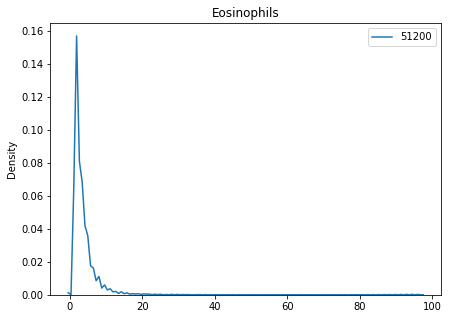

   itemid  patients      mean  median       std
0   51200     44246  1.696921     0.9  2.815068
Eosinophils


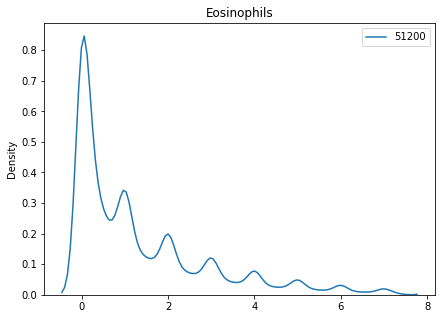

   itemid  patients      mean  median       std
0   51200     43719  1.325141     0.8  1.589998
Hematocrit


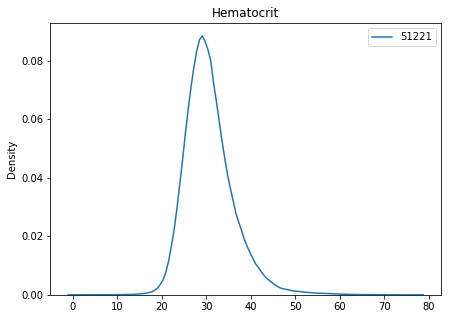

   itemid  patients       mean  median       std
0   51221     57102  30.715236    30.0  5.522901
Hematocrit


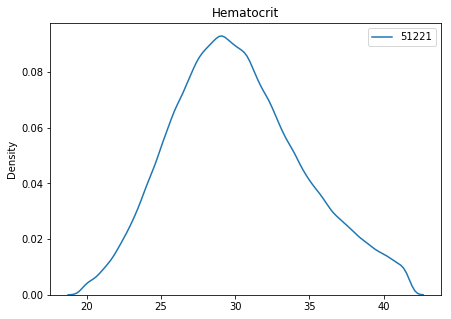

   itemid  patients       mean  median      std
0   51221     50850  30.165867    29.8  4.42401
Hemoglobin


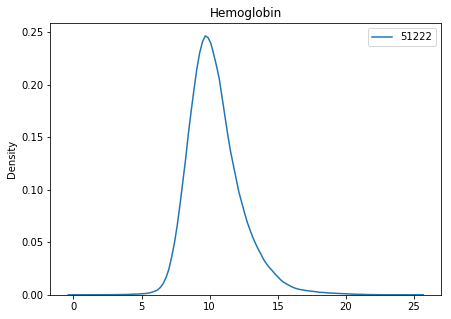

   itemid  patients      mean  median       std
0   51222     56949  10.40664    10.1  1.952585
Hemoglobin


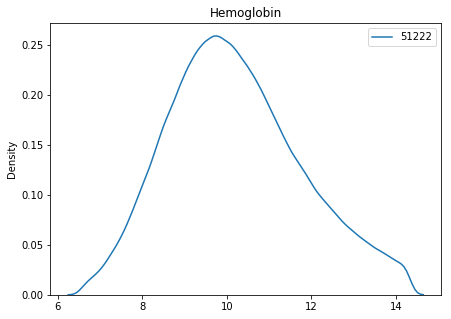

   itemid  patients      mean  median       std
0   51222     50704  10.21074    10.1  1.578415
Lymphocytes


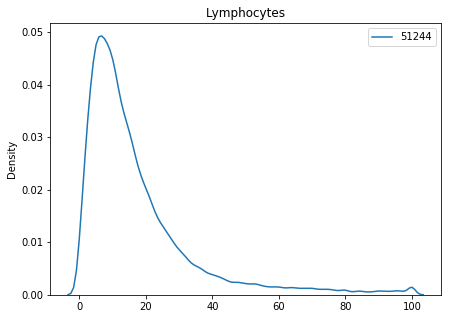

   itemid  patients       mean  median        std
0   51244     44247  17.327375    12.0  16.945853
Lymphocytes


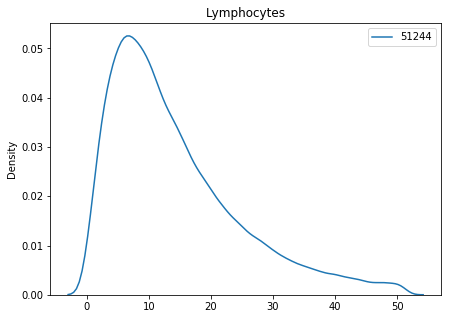

   itemid  patients      mean  median        std
0   51244     42658  14.20631    11.5  10.467422
MCH


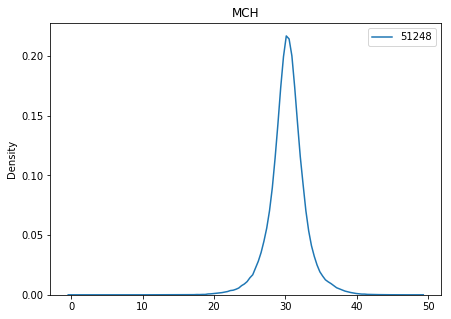

   itemid  patients       mean  median       std
0   51248     56938  30.292456    30.3  2.500433
MCH


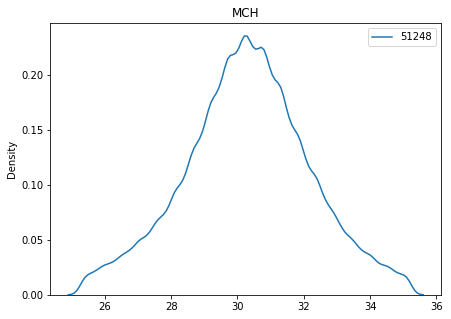

   itemid  patients       mean  median      std
0   51248     51093  30.293534    30.3  1.89795
MCHC


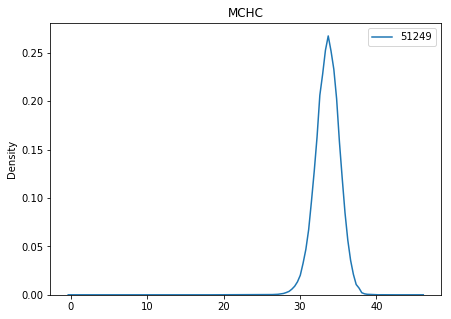

   itemid  patients       mean  median       std
0   51249     56941  33.578911    33.6  1.575285
MCHC


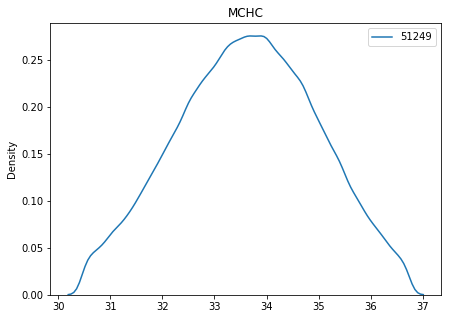

   itemid  patients       mean  median       std
0   51249     56469  33.629729    33.6  1.355099
MCV


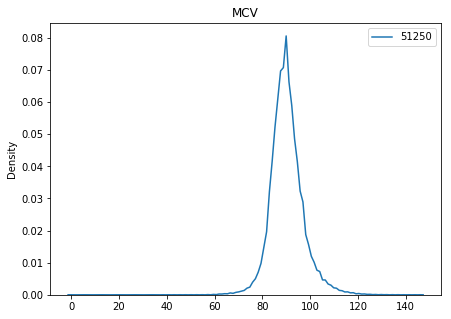

   itemid  patients       mean  median       std
0   51250     56938  90.300854    90.0  6.854976
MCV


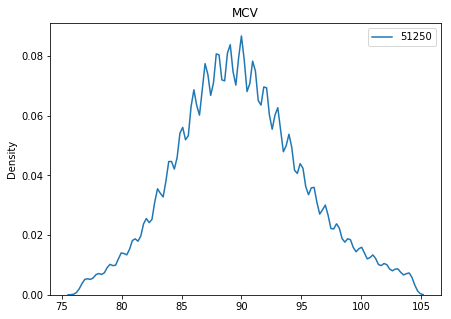

   itemid  patients       mean  median       std
0   51250     51690  89.949363    90.0  5.333222
Monocytes


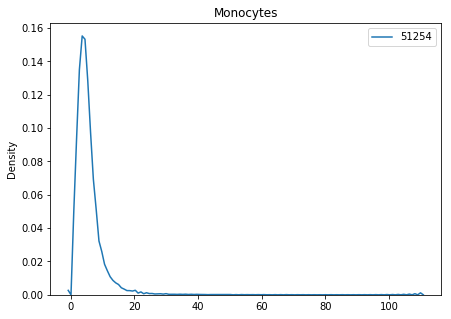

   itemid  patients      mean  median      std
0   51254     44247  5.420769     4.5  4.83894
Monocytes


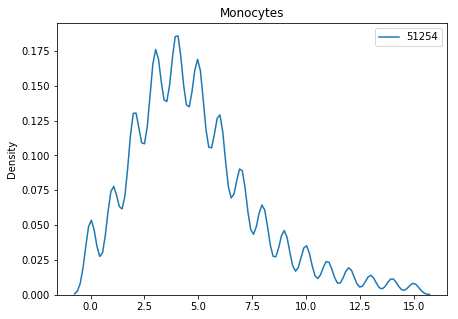

   itemid  patients      mean  median       std
0   51254     43991  4.839786     4.4  2.908904
Neutrophils


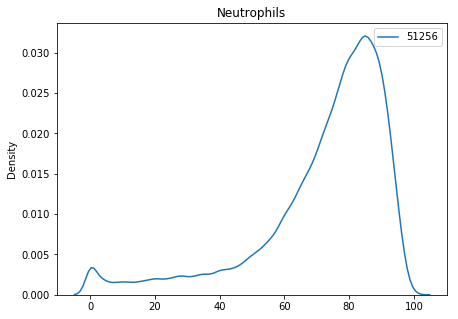

   itemid  patients       mean  median        std
0   51256     44247  71.756738    77.8  20.724846
Neutrophils


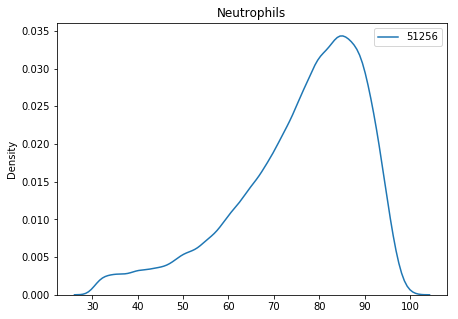

   itemid  patients       mean  median        std
0   51256     42910  75.870686    79.0  14.040839
Platelet Count


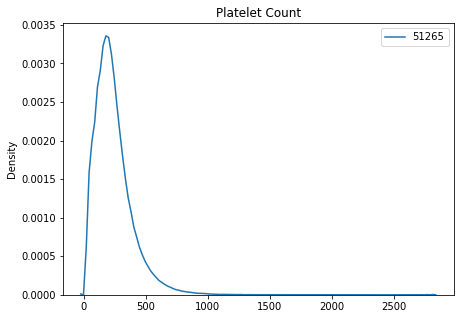

   itemid  patients        mean  median         std
0   51265     56974  236.636716   210.0  152.216988
Platelet Count


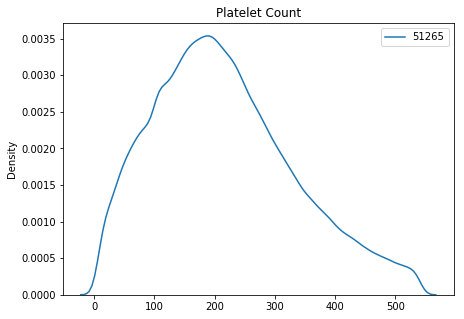

   itemid  patients        mean  median         std
0   51265     56687  216.539314   203.0  116.475239
RDW


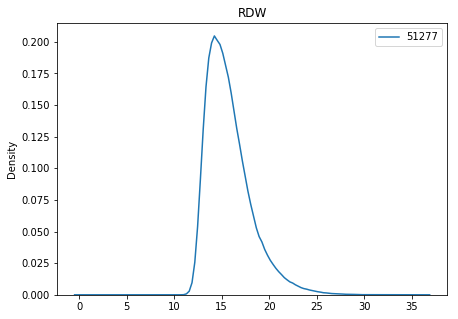

   itemid  patients       mean  median       std
0   51277     56930  15.781929    15.3  2.381525
RDW


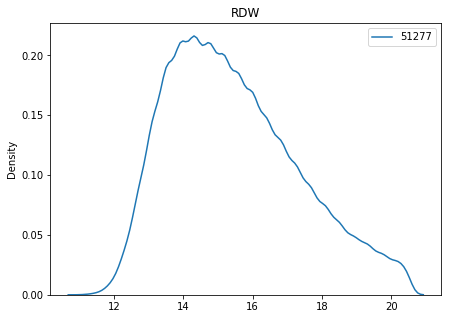

   itemid  patients       mean  median       std
0   51277     56307  15.462302    15.2  1.877729
Red Blood Cells


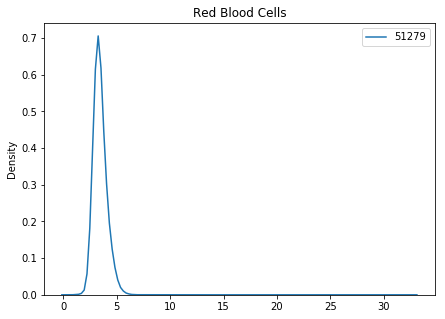

   itemid  patients     mean  median       std
0   51279     56938  3.44839    3.37  0.640932
Red Blood Cells


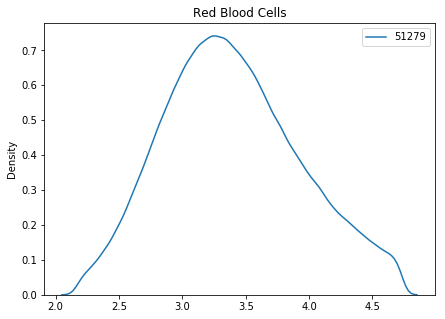

   itemid  patients      mean  median      std
0   51279     53020  3.393687    3.35  0.53689
White blood cells


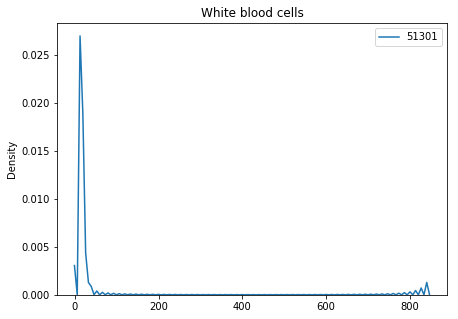

   itemid  patients       mean  median       std
0   51301     56990  11.304008     9.9  9.487122
White blood cells


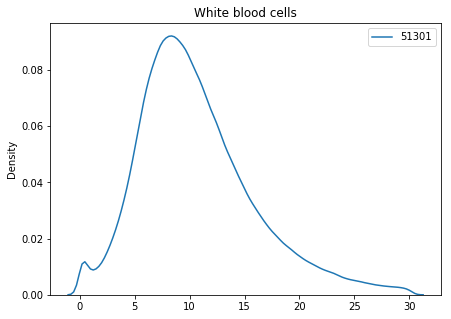

   itemid  patients       mean  median       std
0   51301     56714  10.648374     9.8  5.250798
Anion Gap


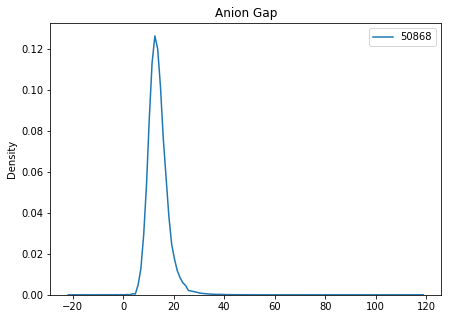

   itemid  patients       mean  median       std
0   50868     52808  13.772912    13.0  3.882666
Anion Gap


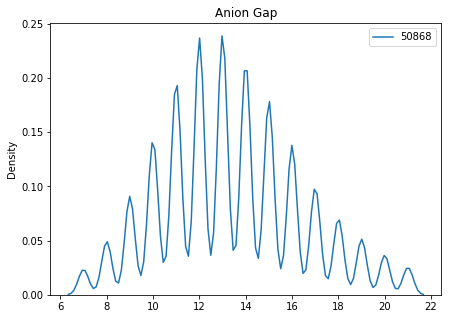

   itemid  patients       mean  median       std
0   50868     52399  13.386109    13.0  3.018437
Bicarbonate


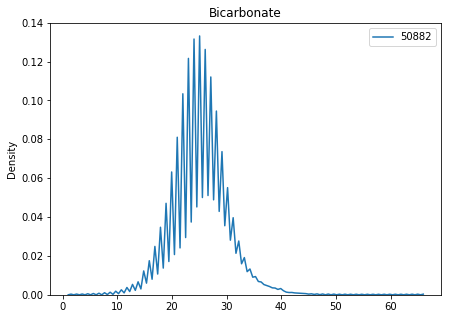

   itemid  patients       mean  median      std
0   50882     52825  25.258974    25.0  5.03566
Bicarbonate


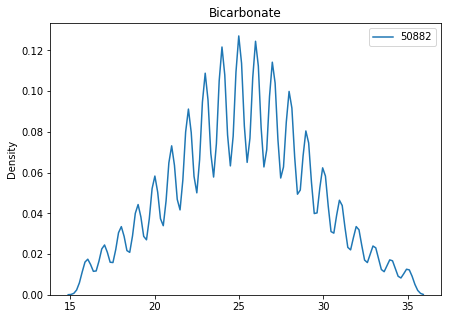

   itemid  patients       mean  median       std
0   50882     52346  25.203012    25.0  4.112488
Calcium (Total)


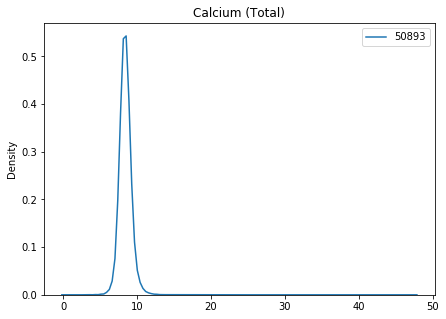

   itemid  patients      mean  median       std
0   50893     49002  8.429568     8.4  0.834552
Calcium (Total)


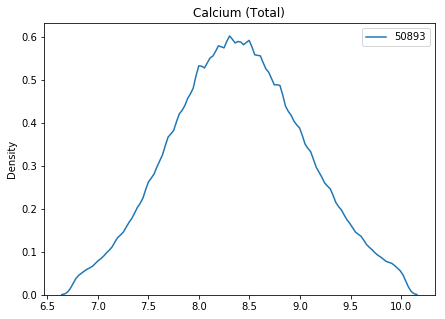

   itemid  patients     mean  median       std
0   50893     48304  8.39245     8.4  0.658553
Chloride


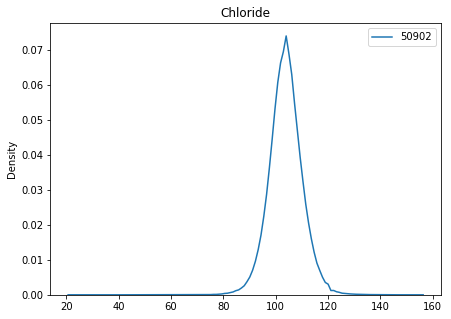

   itemid  patients        mean  median       std
0   50902     52852  103.779464   104.0  6.303991
Chloride


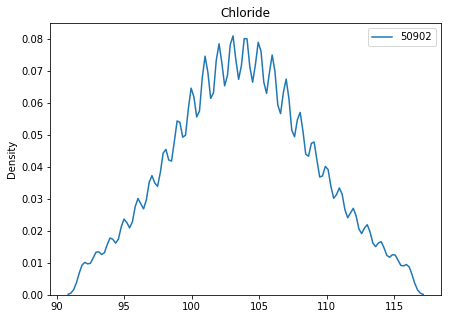

   itemid  patients        mean  median       std
0   50902     52650  103.797622   104.0  5.208996
Creatinine


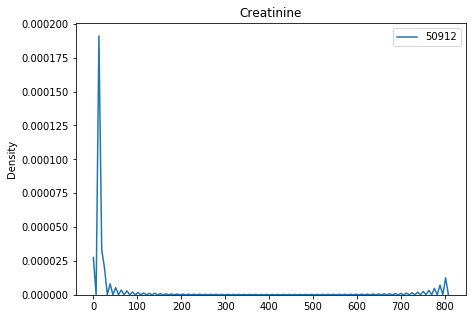

   itemid  patients      mean  median       std
0   50912     50996  1.530655     1.0  1.895441
Creatinine


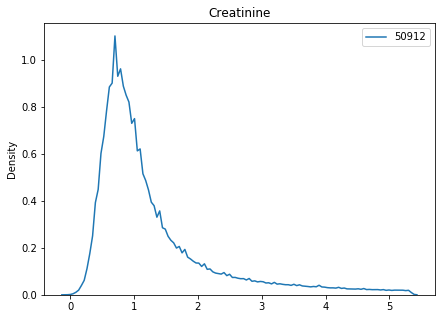

   itemid  patients     mean  median       std
0   50912     50367  1.29179     1.0  0.950898
Glucose


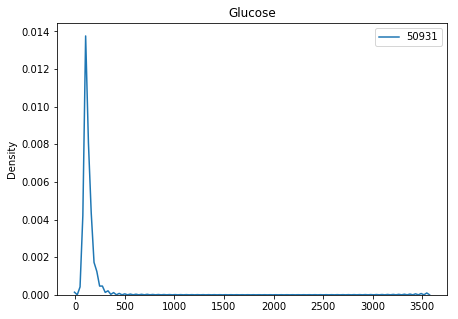

   itemid  patients        mean  median        std
0   50931     50395  132.756433   119.0  66.444797
Glucose


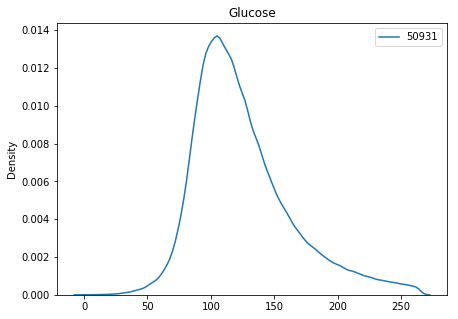

   itemid  patients        mean  median        std
0   50931     50259  125.195806   117.0  38.706394
Magnesium


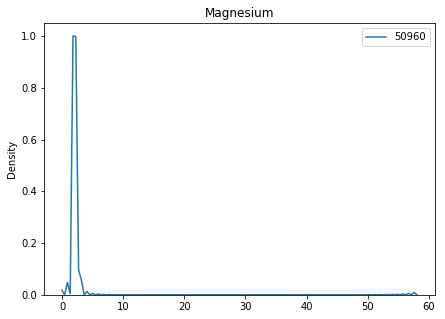

   itemid  patients      mean  median       std
0   50960     49762  2.039457     2.0  0.409426
Magnesium


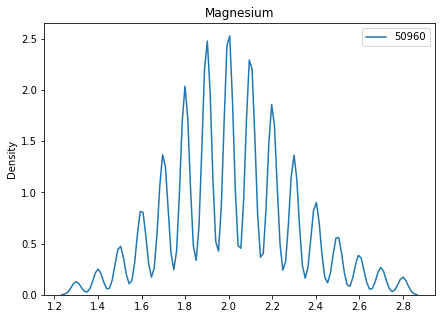

   itemid  patients      mean  median       std
0   50960     49598  2.018965     2.0  0.290193
Potassium


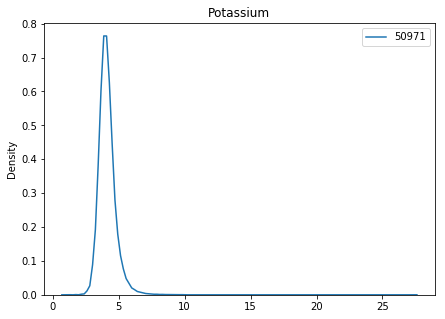

   itemid  patients      mean  median       std
0   50971     52876  4.126318     4.0  0.650398
Potassium


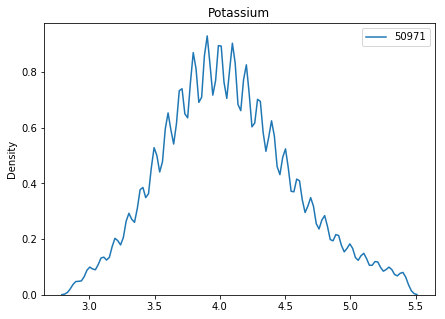

   itemid  patients      mean  median      std
0   50971     52437  4.065845     4.0  0.50293
Sodium


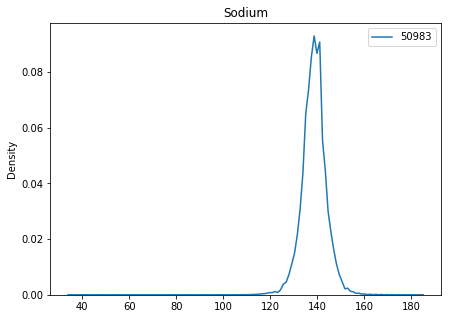

   itemid  patients        mean  median       std
0   50983     52859  138.617959   139.0  5.133123
Sodium


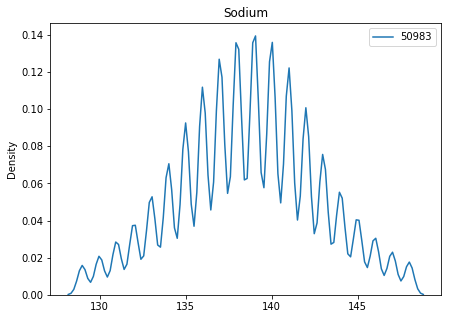

   itemid  patients        mean  median       std
0   50983     52660  138.621929   139.0  4.044598
Urea Nitrogen


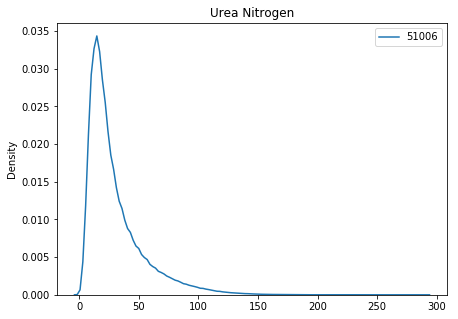

   itemid  patients      mean  median        std
0   51006     51008  30.02692    22.0  23.804153
Urea Nitrogen


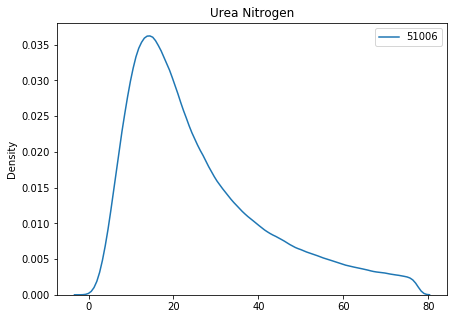

   itemid  patients       mean  median        std
0   51006     50611  25.961412    21.0  16.451756
PTT


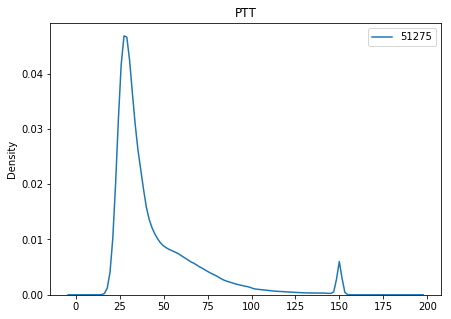

   itemid  patients       mean  median        std
0   51275     48063  44.691134    34.7  25.790675
PTT


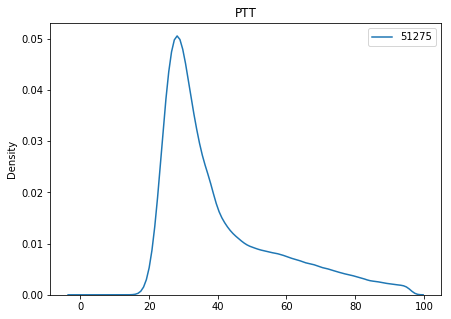

   itemid  patients       mean  median        std
0   51275     47959  40.228854    33.8  16.894065
pH


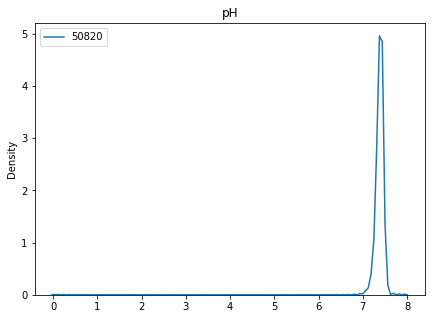

   itemid  patients     mean  median       std
0   50820     38917  7.37929    7.39  0.087134
pH


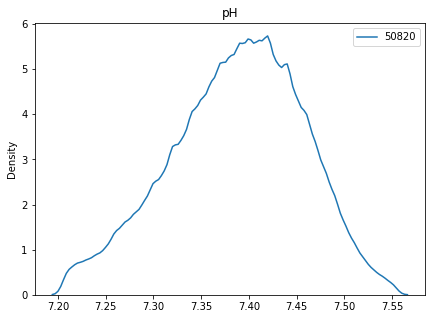

   itemid  patients      mean  median       std
0   50820     38505  7.387274    7.39  0.069314
HR


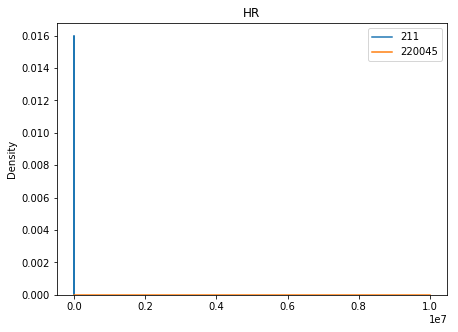

   itemid  patients        mean  median          std
0     211     34901  108.861212    97.0    36.126095
1  220045     21924   91.039794    86.0  6017.072932
HR


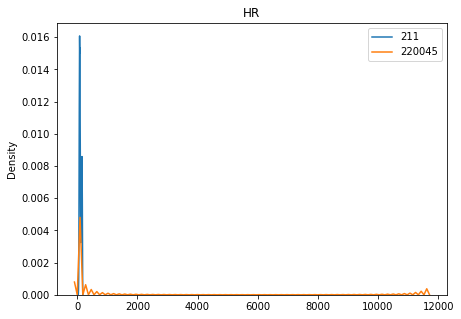

   itemid  patients        mean  median        std
0     211     34893  108.240200    97.0  35.464783
1  220045     21924   87.388417    86.0  20.725913
Temperature F


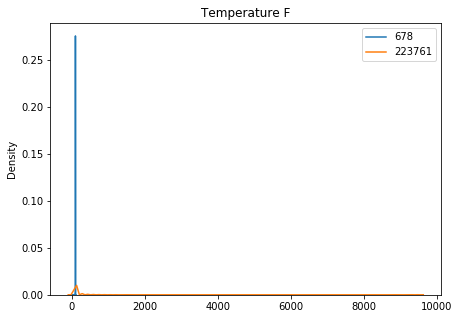

   itemid  patients       mean     median        std
0     678     26642  98.571834  98.599998   2.668473
1  223761     21673  98.407970  98.300000  14.681127
Temperature F


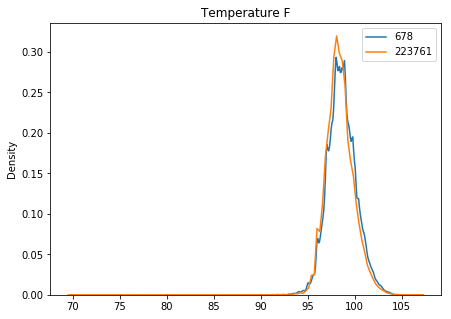

   itemid  patients       mean     median       std
0     678     26600  98.634571  98.599998  1.499277
1  223761     21650  98.432121  98.400000  1.439958
BP systolic


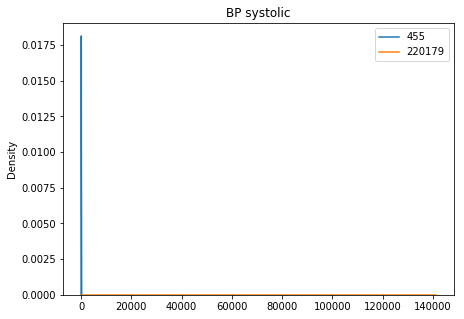

   itemid  patients        mean  median         std
0     455     26429  120.014098   118.0   23.536775
1  220179     21685  120.458251   118.0  249.608552
BP systolic


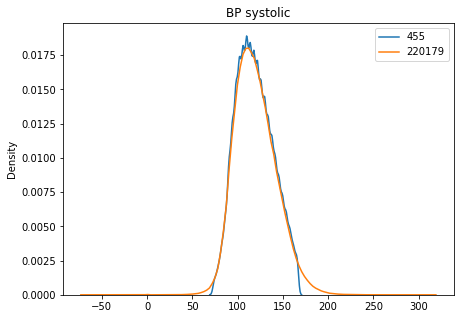

   itemid  patients        mean  median        std
0     455     26380  118.756691   117.0  20.188618
1  220179     21685  119.878283   118.0  22.546624
BP mean


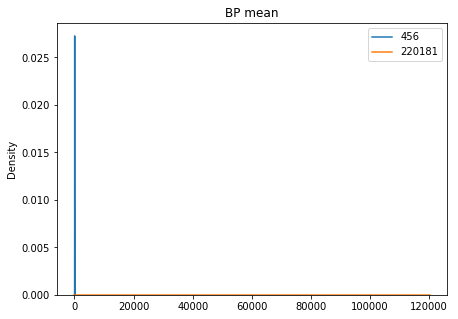

   itemid  patients       mean     median         std
0     456     26397  77.225114  75.666702   15.753650
1  220181     21676  76.673120  75.000000  174.583058
BP mean


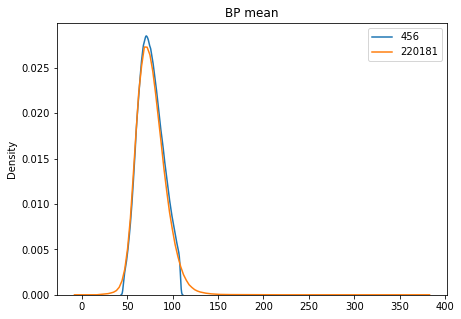

   itemid  patients       mean  median        std
0     456     26355  76.149093    75.0  13.446643
1  220181     21676  76.303422    75.0  15.709556
Respiratory rate


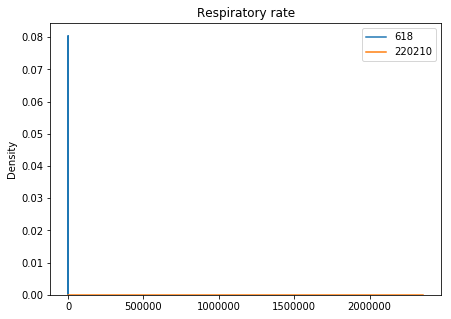

   itemid  patients       mean  median          std
0     618     27195  20.133307    20.0     6.406810
1  220210     21913  20.923463    20.0  1423.805365
Respiratory rate


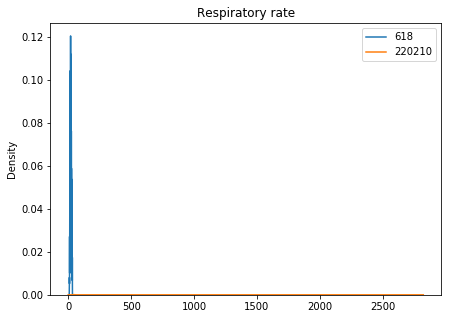

   itemid  patients       mean  median       std
0     618     27189  19.633483    19.0  5.247087
1  220210     21913  20.059210    20.0  7.150209
BP diastolic


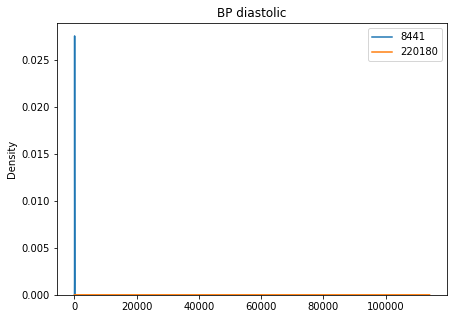

   itemid  patients       mean  median         std
0    8441     26411  58.027487    57.0   15.567736
1  220180     21685  65.183290    61.0  389.373326
BP diastolic


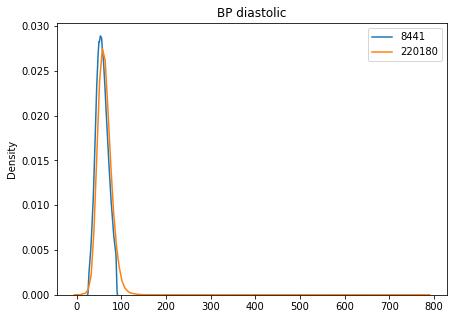

   itemid  patients       mean  median        std
0    8441     26381  57.071619    56.0  13.307924
1  220180     21685  62.828153    61.0  15.628841
BUN


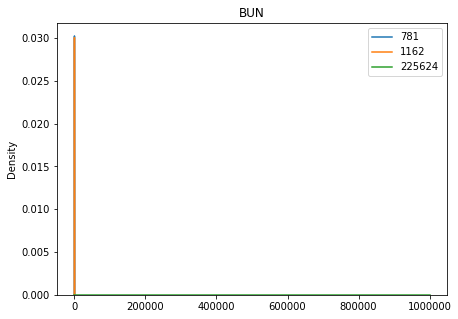

   itemid  patients       mean  median          std
0     781     27354  32.960824    24.0    25.892186
1    1162     21108  32.887724    25.0    25.663993
2  225624     24062  38.393725    24.0  2561.058040
BUN


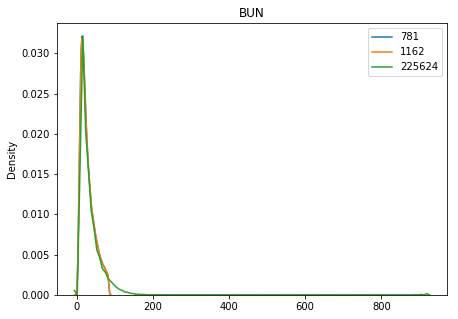

   itemid  patients       mean  median        std
0     781     27052  28.601002    23.0  18.562277
1    1162     20873  28.685099    23.0  18.542280
2  225624     24062  31.835144    24.0  25.547410
Phosphorus


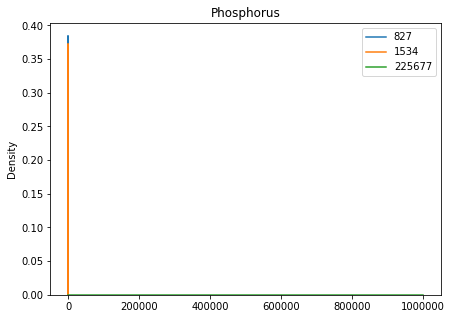

   itemid  patients       mean  median          std
0     827     24839   3.666046     3.4     1.451076
1    1534     20585   3.649682     3.4     1.452145
2  225677     22617  10.940608     3.3  2717.259785
Phosphorus


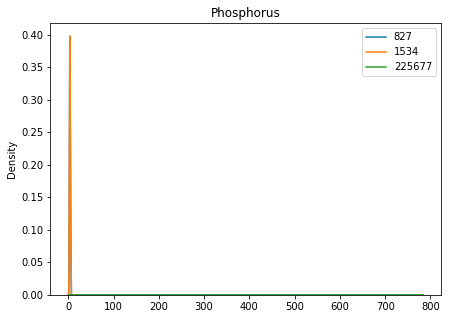

   itemid  patients      mean  median       std
0     827     24519  3.468636     3.4  1.070608
1    1534     20060  3.449842     3.3  1.078937
2  225677     22617  3.557081     3.3  2.606914
Admission weight


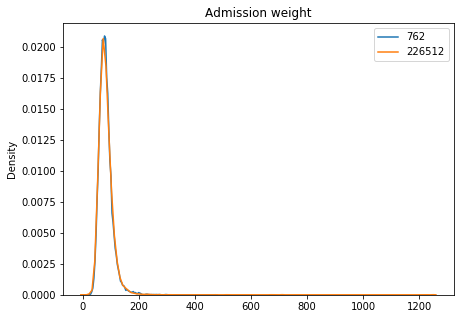

   itemid  patients       mean  median        std
0     762     20045  81.149934    78.0  23.625398
1  226512     21920  81.054447    77.8  26.085891
Admission weight


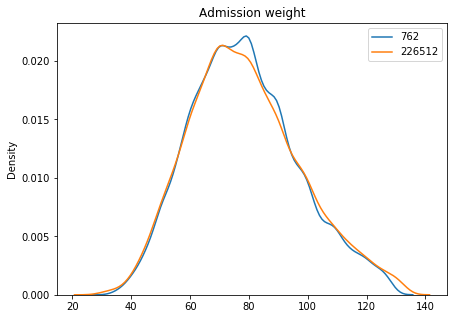

   itemid  patients       mean     median        std
0     762     19417  78.470511  77.199997  18.189996
1  226512     21274  78.777697  77.000000  19.044659
41271881
58288
36740376
58275


In [13]:
sigma = 2
new_df = pd.DataFrame(columns=['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'new_id', 'name'])

for n in new_ids:
    # Find just a single new id and its associated stats. Merge the stats onto the df
    temp_df = df[df['new_id']==n]
    stats = compare_itemids(temp_df)[['itemid', 'mean', 'std']]
    temp_df = pd.merge(temp_df, stats, how='left', left_on='itemid', right_on='itemid')
    
    # Find outliers (based on sigma * std dev), setting these to np.nan and then looking at the new distributions
    temp_df['lower'] = temp_df['mean'] - (sigma * temp_df['std'])
    temp_df['upper'] = temp_df['mean'] + (sigma * temp_df['std'])
    temp_df['valuenum'] = np.where((temp_df['valuenum'] > temp_df['lower']) & (temp_df['valuenum'] < temp_df['upper']),
                                  temp_df['valuenum'], np.nan)
    compare_itemids(temp_df)
    temp_df.dropna(inplace=True)
    new_df = new_df.append(temp_df[['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'new_id', 'name']])

# Reset index
new_df.reset_index(drop=True, inplace=True)

print(len(df))
print(df.hadm_id.nunique())
print(len(new_df))
print(new_df.hadm_id.nunique())

## Manual cleaning

In [14]:
# Find equivalent min and max values from Carevue

# Heart_rate
hr_low = new_df[new_df['itemid']==211].valuenum.min()
hr_high = new_df[new_df['itemid']==211].valuenum.max()

# Respiratory_rate
rr_low = new_df[new_df['itemid']==618].valuenum.min()
rr_high = new_df[new_df['itemid']==618].valuenum.max()

# Phosphorus
p_low = new_df[(new_df['itemid']==827) | (new_df['itemid']==1534)].valuenum.min()
p_high = new_df[(new_df['itemid']==827) | (new_df['itemid']==1534)].valuenum.max()

In [15]:
# HR (Metavision)
def manual_range_change(df, new_id, low, high):
    df['valuenum'] = np.where((df['valuenum']>high) & (df['new_id']==new_id), np.nan, df['valuenum'])
    df['valuenum'] = np.where((df['valuenum']<low) & (df['new_id']==new_id), np.nan, df['valuenum'])
    compare_itemids(df[df['new_id']==new_id])
    df.dropna(inplace=True)
    return df

HR


/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


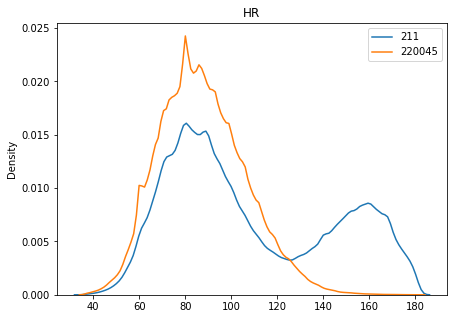

   itemid  patients       mean  median        std
0     211     34893  108.24020    97.0  35.464783
1  220045     21924   87.43777    86.0  18.631746
Respiratory rate


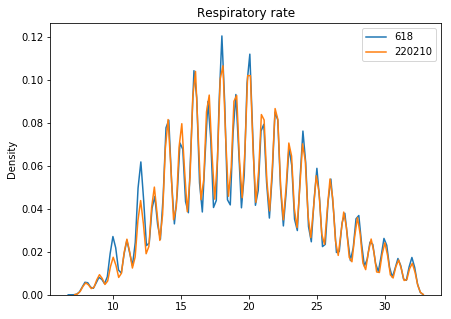

   itemid  patients       mean  median       std
0     618     27189  19.633483    19.0  5.247087
1  220210     21913  19.689696    19.0  5.079569
Phosphorus


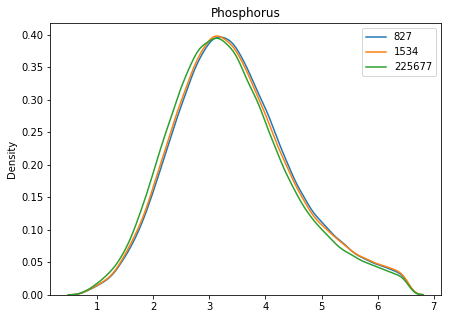

   itemid  patients      mean  median       std
0     827     24519  3.468636     3.4  1.070608
1    1534     20060  3.449842     3.3  1.078937
2  225677     22354  3.377497     3.3  1.072426


In [16]:
new_df = manual_range_change(new_df, 9999018, hr_low, hr_high)
new_df = manual_range_change(new_df, 9999025, rr_low, rr_high)
new_df = manual_range_change(new_df, 9999022, p_low, p_high)

In [17]:
# Get last reading per admission
last_reading = (new_df.sort_values(by=['subject_id', 'hadm_id', 'new_id', 'charttime'])
                      .groupby(['subject_id', 'hadm_id', 'new_id'])
                      .last()
                      .reset_index())

In [18]:
# Pivot
last_reading=(pd.pivot_table(last_reading, values='valuenum', index=['subject_id', 'hadm_id'], columns='name')
                .reset_index())
print(len(last_reading))
last_reading.head()

58275


name,subject_id,hadm_id,Admission weight,Anion Gap,BP diastolic,BP mean,BP systolic,BUN,Basophils,Bicarbonate,Calcium (Total),Chloride,Creatinine,Eosinophils,Glucose,HR,Hematocrit,Hemoglobin,Lymphocytes,MCH,MCHC,MCV,Magnesium,Monocytes,Neutrophils,PTT,Phosphorus,Platelet Count,Potassium,RDW,Red Blood Cells,Respiratory rate,Sodium,Temperature F,Urea Nitrogen,White blood cells,pH
0,2,163353.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,140.0,NaN,NaN,19.0,34.4,33.3,103.0,NaN,10.0,70.0,NaN,NaN,302.0,NaN,15.5,NaN,NaN,NaN,NaN,NaN,22.0,NaN
1,3,145834.0,96.800003,12.0,45.0,68.000000,151.0,17.0,0.3,25.0,8.2,108.0,1.5,2.8,88.0,84.0,34.3,11.2,9.4,29.8,32.6,91.0,2.0,5.6,80.7,35.5,3.2,210.0,4.2,16.3,3.75,19.0,141.0,96.300003,15.0,8.0,7.39
2,4,185777.0,NaN,16.0,73.0,93.000000,133.0,16.0,0.2,25.0,8.8,102.0,0.5,0.6,145.0,101.0,33.8,10.9,7.2,30.3,32.1,94.0,2.2,2.1,90.1,33.2,3.1,388.0,3.4,14.9,3.58,25.0,140.0,98.099998,20.0,12.3,7.47
3,5,178980.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,140.0,NaN,NaN,16.0,NaN,34.7,NaN,NaN,5.0,79.0,NaN,NaN,309.0,NaN,16.7,3.96,NaN,NaN,NaN,NaN,13.9,NaN
4,6,107064.0,NaN,10.0,57.0,91.333298,160.0,73.0,0.1,21.0,8.0,105.0,0.9,0.1,103.0,71.0,29.3,9.4,0.8,29.1,32.0,91.0,1.6,1.6,97.5,51.3,NaN,331.0,4.4,14.7,3.22,12.0,132.0,96.500000,17.0,11.9,7.31


In [19]:
def select_patients_and_select_chartevents(diagnosis_id, diagnosis_name, plot):
    
    print('=============')
    print(diagnosis_name)
    print('=============')
    
    df = select_test_groups(diagnosis = diagnosis_id,
                        first_diagnosis_only = True,
                        exclude_newborns = True,
                        exclude_deaths = True,
                        match_control = True,
                        show_stats_graphs = True)
    
    # Make a list of the cols to keep from the admissions df
    non_chart_cols = ['subject_id', 'hadm_id', 'target', 'gender', 'age_adm_bucket']
    
    # Merge on the chart events
    df = df[non_chart_cols]
    df = pd.merge(df, last_reading, how='left', left_on=['subject_id', 'hadm_id'], right_on=['subject_id', 'hadm_id'])
    
    if plot:
        # Plot a KDE for all remaining cols
        cols = [c for c in df.columns if c not in non_chart_cols]
        for c in cols:
            plot_KDE(df, 'target', 1, 0, c)

    return df

acute_respiratory_failure
Original base group size: 29337
Sampled base group size: 23820
Subject group size: 4596


/Users/James/Desktop/YourMD/machine_learning/mimic/src/processing/stats.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)


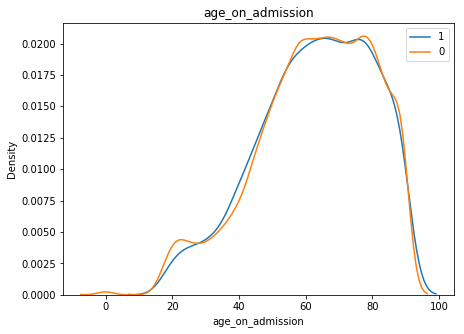

<Figure size 432x288 with 0 Axes>

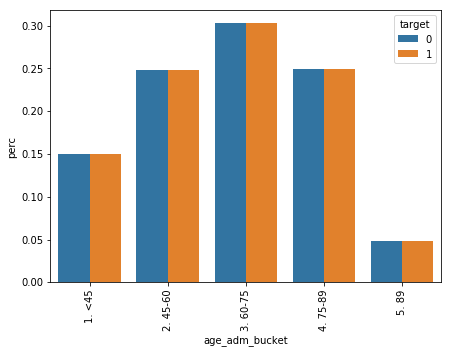

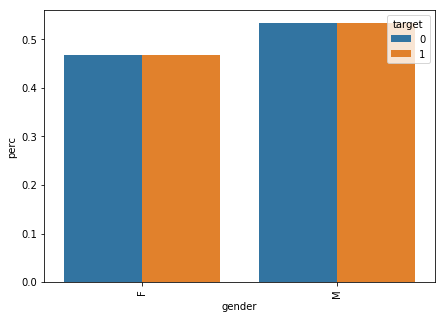

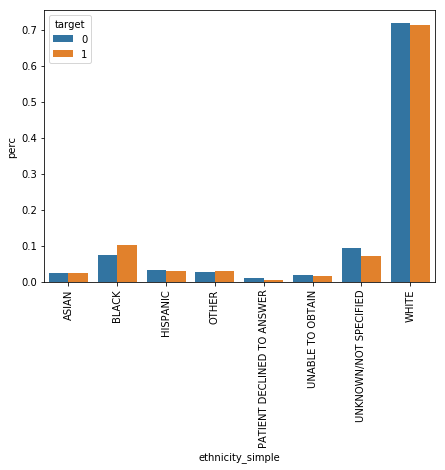

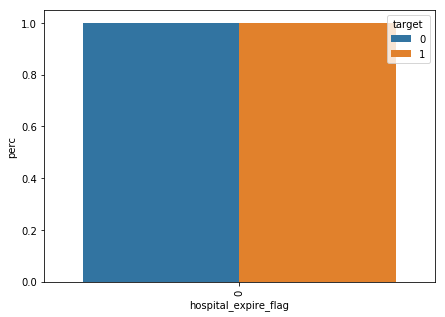

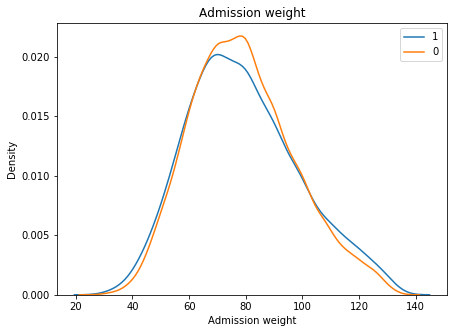

<Figure size 432x288 with 0 Axes>

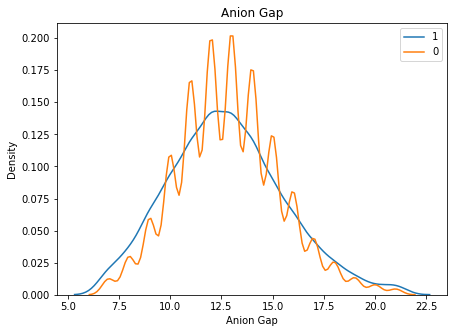

<Figure size 432x288 with 0 Axes>

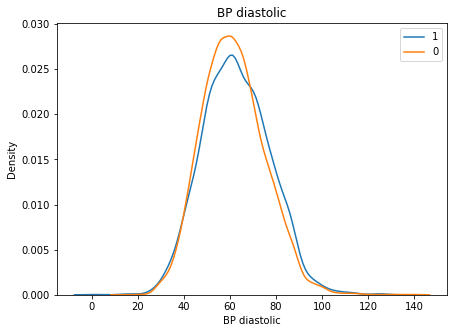

<Figure size 432x288 with 0 Axes>

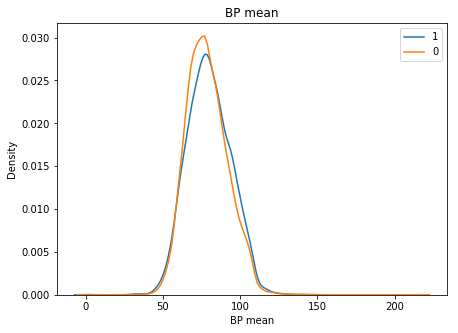

<Figure size 432x288 with 0 Axes>

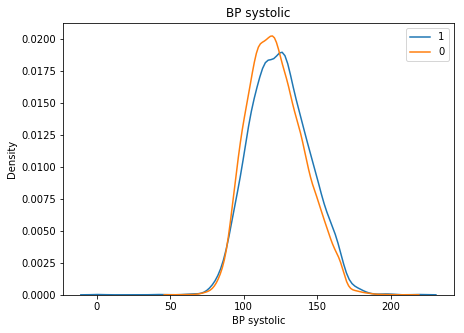

<Figure size 432x288 with 0 Axes>

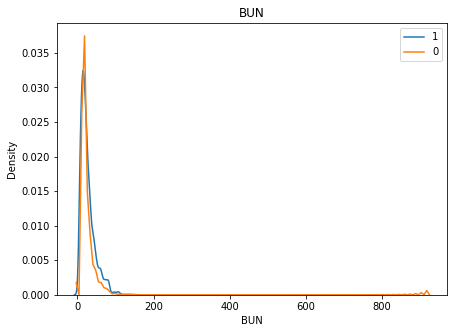

<Figure size 432x288 with 0 Axes>

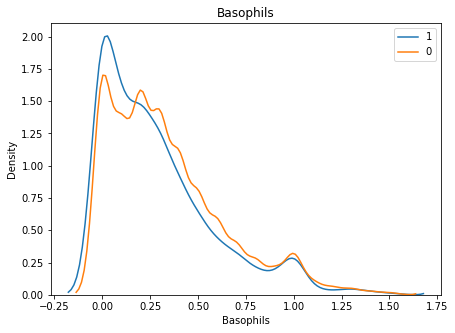

<Figure size 432x288 with 0 Axes>

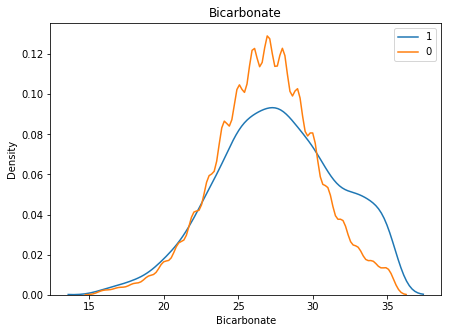

<Figure size 432x288 with 0 Axes>

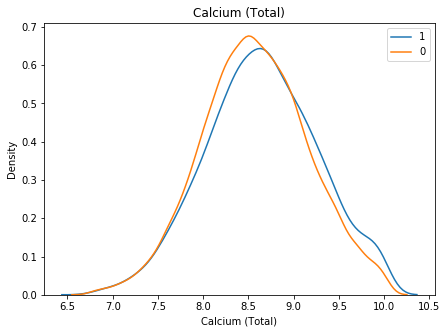

<Figure size 432x288 with 0 Axes>

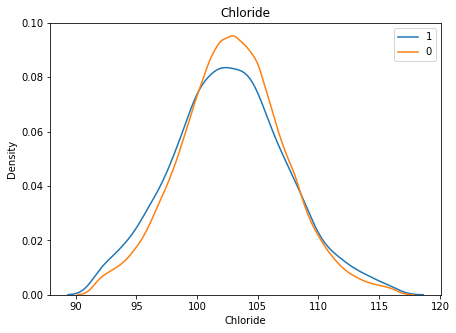

<Figure size 432x288 with 0 Axes>

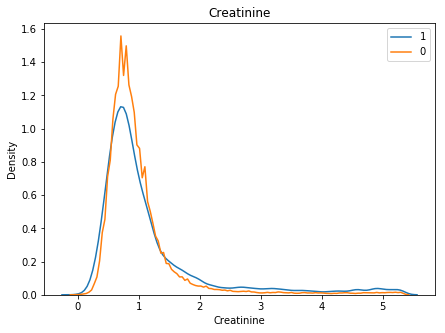

<Figure size 432x288 with 0 Axes>

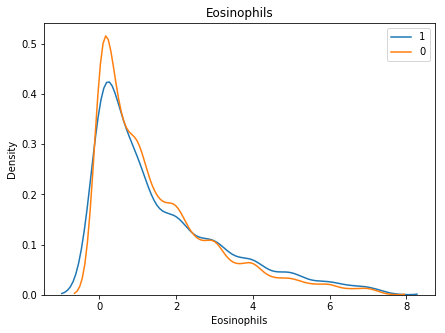

<Figure size 432x288 with 0 Axes>

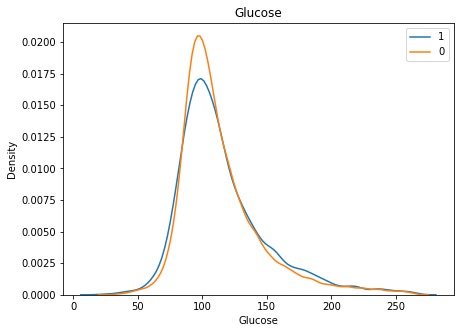

<Figure size 432x288 with 0 Axes>

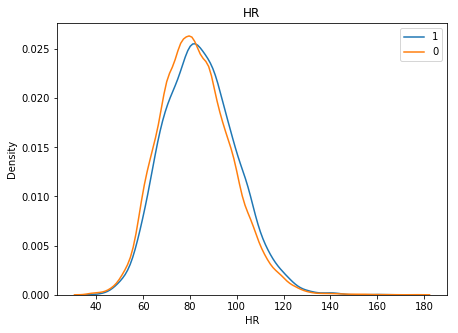

<Figure size 432x288 with 0 Axes>

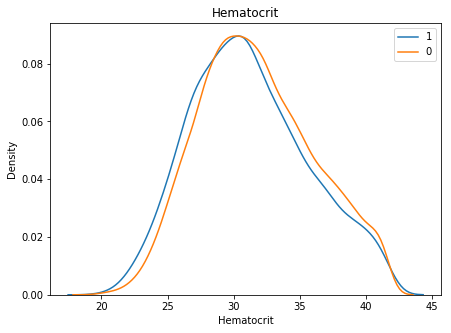

<Figure size 432x288 with 0 Axes>

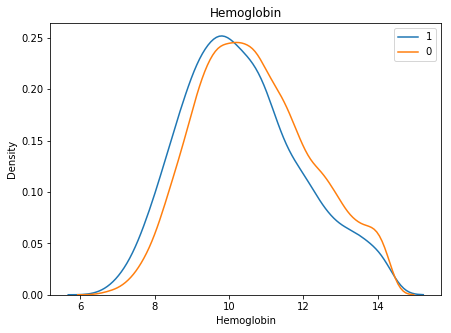

<Figure size 432x288 with 0 Axes>

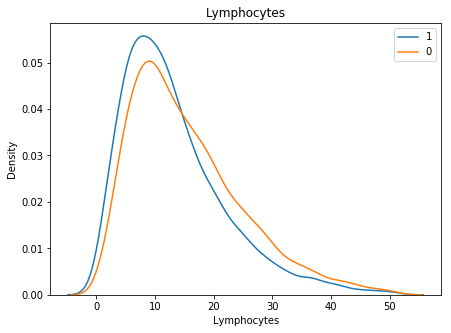

<Figure size 432x288 with 0 Axes>

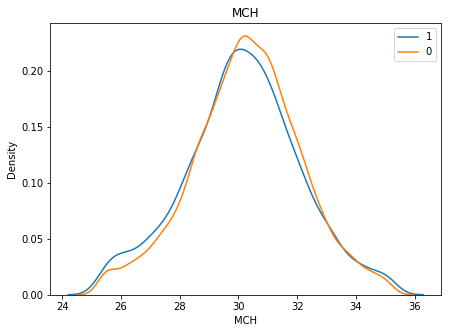

<Figure size 432x288 with 0 Axes>

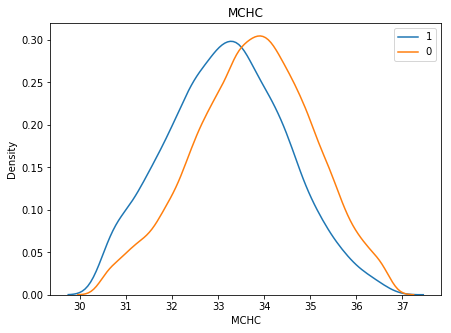

<Figure size 432x288 with 0 Axes>

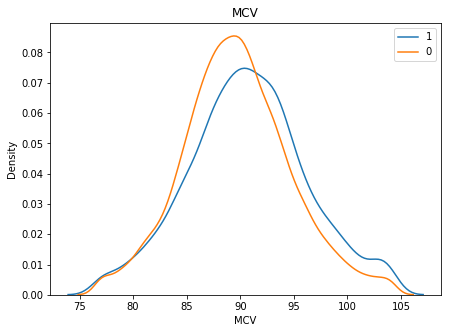

<Figure size 432x288 with 0 Axes>

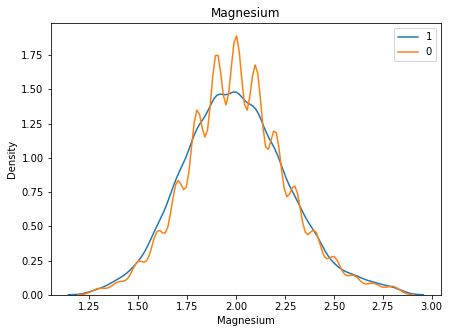

<Figure size 432x288 with 0 Axes>

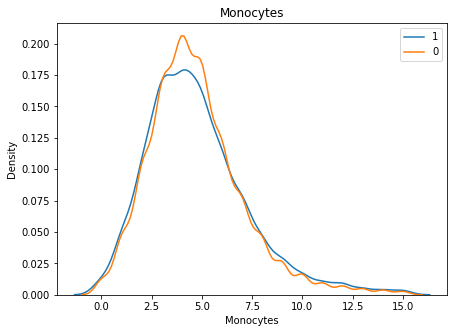

<Figure size 432x288 with 0 Axes>

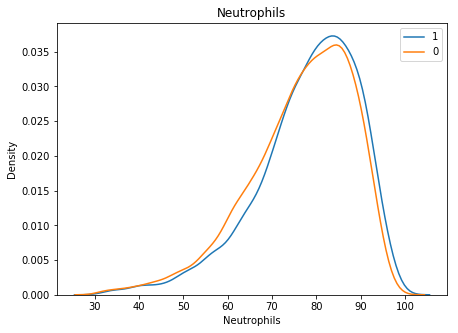

<Figure size 432x288 with 0 Axes>

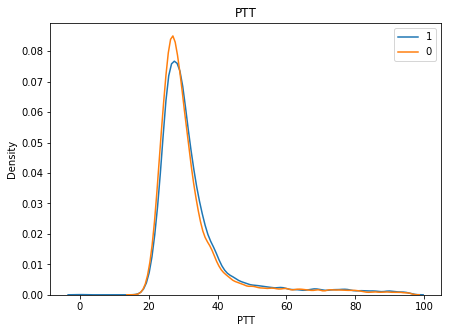

<Figure size 432x288 with 0 Axes>

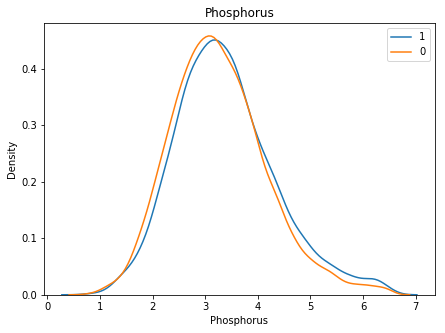

<Figure size 432x288 with 0 Axes>

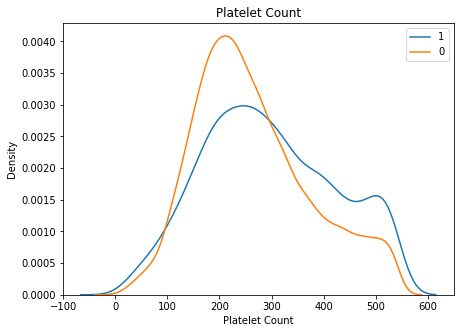

<Figure size 432x288 with 0 Axes>

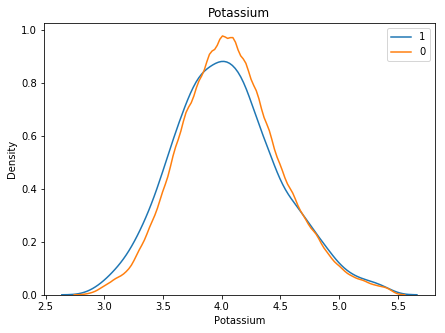

<Figure size 432x288 with 0 Axes>

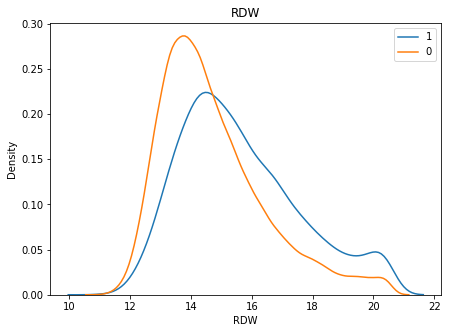

<Figure size 432x288 with 0 Axes>

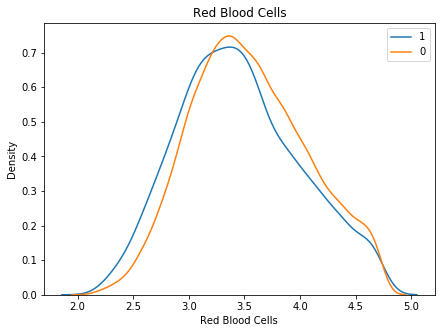

<Figure size 432x288 with 0 Axes>

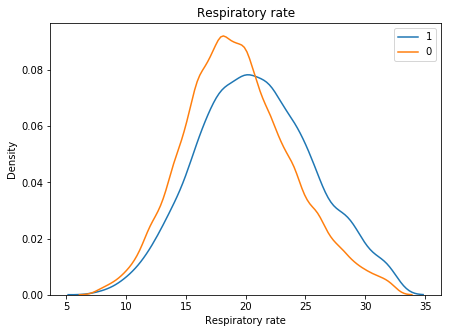

<Figure size 432x288 with 0 Axes>

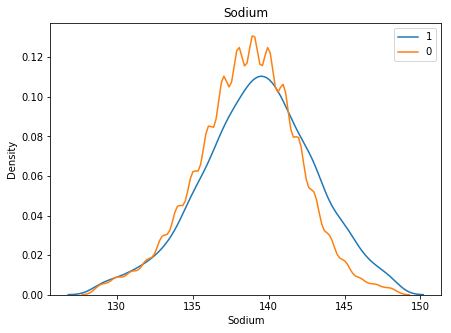

<Figure size 432x288 with 0 Axes>

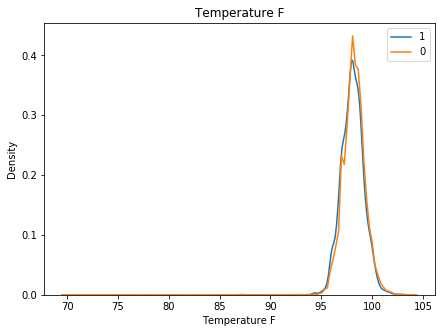

<Figure size 432x288 with 0 Axes>

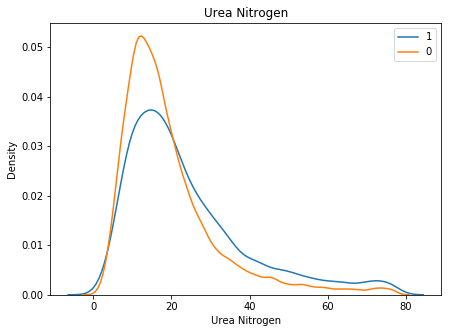

<Figure size 432x288 with 0 Axes>

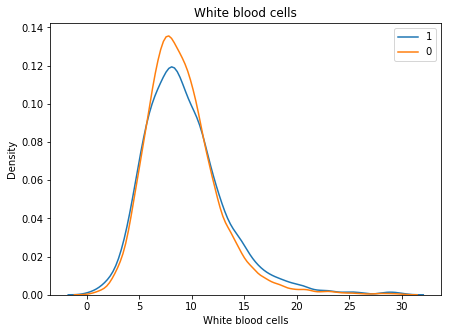

<Figure size 432x288 with 0 Axes>

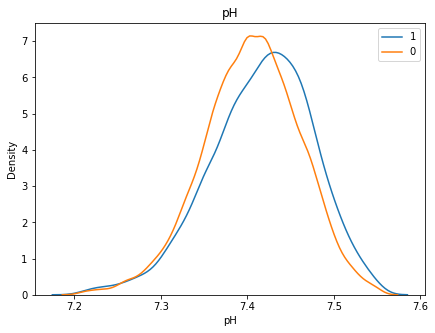

<Figure size 432x288 with 0 Axes>

In [20]:
df = select_patients_and_select_chartevents('51881', 'acute_respiratory_failure', plot=True)
df.to_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', 'cleaned_respiratory_failure.csv')))

In [21]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(10, 150)),
    'learning_rate': list(np.linspace(0.001, 0.5)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_data_in_leaf': list(range(10, 250, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.001, 1)),
    'subsample': list(np.linspace(0.5, 1)),
    'is_unbalance': [True, False],
    'min_split_gain': list(np.linspace(0.001, 1)),
    'min_data_in_leaf': list(np.arange(1, 200, 3)),
}

In [24]:
def tune_lgb(df, param_grid, runs):
    
    # Dummy variables for age bucket and gender
    df = pd.get_dummies(df)

    # Shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    # Split features and labels
    features = df.drop(columns=['subject_id', 'hadm_id', 'target'])
    labels = np.array(df.target.tolist())

    # Impute missing values
    imputer = Imputer(strategy = 'median')
    imputer.fit(features)
    features = imputer.transform(features)

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1)) 
    scaler.fit(features)
    features = scaler.transform(features)
    
    ## -- Train a Light GBM
    df_cols = list(param_grid.keys())
    df_cols = df_cols + ['training_score', 'valid_score']

    runs_df = pd.DataFrame(columns=df_cols)
    total_runs = runs
    run =0

    while run < total_runs:

        run += 1

        # Select the random parameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # Add constant params
        random_params['n_thread'] = 1
        random_params['n_estimators'] = 10000
        random_params['metric'] = 'auc'

        print('=========')
        print('RUN IS ' + str(run))
        print('=========')

        metrics, train_score, valid_score = train_lgb(features = features,
                                                     labels = labels,
                                                     n_folds = 5,
                                                     params = random_params,
                                                     eval_metric = 'auc',
                                                     early_stopping_rounds = 250)

        temp_df = pd.DataFrame(columns=df_cols)

        for c in list(param_grid.keys()):
            temp_df.loc[0, c] = random_params[c]

        temp_df.loc[0, 'training_score'] = train_score
        temp_df.loc[0, 'valid_score'] = valid_score

        runs_df = runs_df.append(temp_df)

        del temp_df, train_score, valid_score
        
    return runs_df

In [25]:
runs_df = tune_lgb(df, param_grid, 50)

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


RUN IS 1
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[23]	valid's auc: 0.811388	train's auc: 0.950254
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[11]	valid's auc: 0.806968	train's auc: 0.896878
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.814085	train's auc: 0.905088
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[13]	valid's auc: 0.787734	train's auc: 0.910216
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[16]	valid's auc: 0.801874	train's auc: 0.925305
      fold     train     valid
0        0  0.950254  0.811388
1        1  0.896878  0.806968
2        2  0.905088  0.814085
3        3  0.910216  0.787734
4        4  0.925305  0.801874
5  overall  0.917548  0.804193
RUN IS 2
LGB starting
Trai

Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.80484	train's auc: 0.948194
Early stopping, best iteration is:
[356]	valid's auc: 0.805001	train's auc: 0.936259
Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.823342	train's auc: 0.946778
Early stopping, best iteration is:
[423]	valid's auc: 0.823873	train's auc: 0.942169
      fold     train     valid
0        0  0.940998  0.827297
1        1  0.934218  0.830450
2        2  0.941294  0.832394
3        3  0.936259  0.805001
4        4  0.942169  0.823873
5  overall  0.938988  0.823811
RUN IS 9
LGB starting
Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.821073	train's auc: 0.978719
Early stopping, best iteration is:
[316]	valid's auc: 0.823618	train's auc: 0.948885
Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.826756	train's auc: 0.978733
Early stopping, best iteration is:
[258]	valid's auc: 0

Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[79]	valid's auc: 0.808291	train's auc: 0.909594
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[78]	valid's auc: 0.783029	train's auc: 0.912105
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[67]	valid's auc: 0.79487	train's auc: 0.899109
      fold     train     valid
0        0  0.907941  0.807154
1        1  0.906125  0.807458
2        2  0.909594  0.808291
3        3  0.912105  0.783029
4        4  0.899109  0.794870
5  overall  0.906975  0.800191
RUN IS 16
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[92]	valid's auc: 0.82019	train's auc: 0.980396
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.820458	train's auc: 0.927679
Training until validation s

Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[34]	valid's auc: 0.794713	train's auc: 0.894385
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[19]	valid's auc: 0.772237	train's auc: 0.86457
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.79242	train's auc: 0.903929
      fold     train     valid
0        0  0.904798  0.796957
1        1  0.903709  0.810139
2        2  0.894385  0.794713
3        3  0.864570  0.772237
4        4  0.903929  0.792420
5  overall  0.894278  0.793492
RUN IS 24
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[26]	valid's auc: 0.80506	train's auc: 0.898686
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[17]	valid's auc: 0.807862	train's auc: 0.876113
Training until validation sc

Early stopping, best iteration is:
[13]	valid's auc: 0.81601	train's auc: 0.897282
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[129]	valid's auc: 0.795458	train's auc: 0.995215
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[110]	valid's auc: 0.809337	train's auc: 0.991941
      fold     train     valid
0        0  0.996617  0.815833
1        1  0.999843  0.819052
2        2  0.897282  0.816010
3        3  0.995215  0.795458
4        4  0.991941  0.809337
5  overall  0.976180  0.796219
RUN IS 31
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[30]	valid's auc: 0.810697	train's auc: 0.913015
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[18]	valid's auc: 0.81341	train's auc: 0.881887
Training until validation scores don't improve for 250 rounds.
Early stopping, best iter

Early stopping, best iteration is:
[34]	valid's auc: 0.792688	train's auc: 0.962325
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[24]	valid's auc: 0.809501	train's auc: 0.937182
      fold     train     valid
0        0  0.958037  0.812496
1        1  0.970073  0.820500
2        2  0.965661  0.814524
3        3  0.962325  0.792688
4        4  0.937182  0.809501
5  overall  0.958656  0.809718
RUN IS 39
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[22]	valid's auc: 0.812632	train's auc: 0.861195
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[18]	valid's auc: 0.817192	train's auc: 0.851472
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[36]	valid's auc: 0.81776	train's auc: 0.881694
Training until validation scores don't improve for 250 rounds.
Early stopping, best itera

Early stopping, best iteration is:
[10]	valid's auc: 0.783039	train's auc: 0.865101
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[10]	valid's auc: 0.759926	train's auc: 0.862113
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[32]	valid's auc: 0.764906	train's auc: 0.926137
      fold     train     valid
0        0  0.860076  0.780688
1        1  0.915621  0.775603
2        2  0.865101  0.783039
3        3  0.862113  0.759926
4        4  0.926137  0.764906
5  overall  0.885810  0.770223
RUN IS 47
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[112]	valid's auc: 0.815054	train's auc: 0.993638
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[122]	valid's auc: 0.815446	train's auc: 0.9947
Training until validation scores don't improve for 250 rounds.
Early stopping, best iter

Early stopping, best iteration is:
[11]	valid's auc: 0.796668	train's auc: 0.904317
      fold     train     valid
0        0  0.928047  0.800533
1        1  0.892072  0.799266
2        2  0.910297  0.807893
3        3  0.902211  0.781792
4        4  0.904317  0.796668
5  overall  0.907389  0.797106
RUN IS 55
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[147]	valid's auc: 0.824778	train's auc: 0.958974
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[134]	valid's auc: 0.82708	train's auc: 0.952978
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[191]	valid's auc: 0.831923	train's auc: 0.975867
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[194]	valid's auc: 0.806133	train's auc: 0.977339
Training until validation scores don't improve for 250 rounds.
Early stopping, best i

Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.815968	train's auc: 0.988454
Early stopping, best iteration is:
[288]	valid's auc: 0.821409	train's auc: 0.959908
      fold     train     valid
0        0  0.977047  0.825607
1        1  0.921322  0.825260
2        2  0.933627  0.827712
3        3  0.926798  0.802580
4        4  0.959908  0.821409
5  overall  0.943741  0.796221
RUN IS 63
LGB starting
Training until validation scores don't improve for 250 rounds.
[500]	valid's auc: 0.811502	train's auc: 0.998006
Early stopping, best iteration is:
[254]	valid's auc: 0.809108	train's auc: 0.998378
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[23]	valid's auc: 0.814624	train's auc: 0.925482
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[247]	valid's auc: 0.806694	train's auc: 0.998695
Training until validation scores don't improve for 250 rounds.
[500]	

Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[42]	valid's auc: 0.789539	train's auc: 0.976884
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[34]	valid's auc: 0.812363	train's auc: 0.96296
      fold     train     valid
0        0  0.978258  0.810146
1        1  0.954251  0.815475
2        2  0.956496  0.822441
3        3  0.976884  0.789539
4        4  0.962960  0.812363
5  overall  0.965770  0.809049
RUN IS 71
LGB starting
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[54]	valid's auc: 0.819641	train's auc: 0.944843
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[46]	valid's auc: 0.822934	train's auc: 0.934553
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[35]	valid's auc: 0.821879	train's auc: 0.918023
Training until validation 

KeyboardInterrupt: 

In [26]:
runs_df.sort_values(by='valid_score', ascending=False)

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_data_in_leaf,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,min_split_gain,training_score,valid_score
0,gbdt,34,0.214857,280000,121,0.265306,0.346939,0.123327,0.765306,True,0.36798,0.943317,0.807512
